# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

In [2]:
# Cargar los datos
file_path = '/datasets/taxi.csv'
data = pd.read_csv(file_path)

# Mostrar las primeras filas
print(data.head())

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


In [3]:
# Información general sobre el DataFrame
print(data.info())

# Revisar valores faltantes
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
datetime      0
num_orders    0
dtype: int64


In [4]:
# Verificar duplicados
print(f"Número de filas duplicadas: {data.duplicated().sum()}")

Número de filas duplicadas: 0


In [5]:
# Eliminar filas duplicadas
data = data.drop_duplicates()

In [6]:
# Verificar si la columna 'datetime' está en el dataset
if 'datetime' in data.columns:
    # Convertir a formato datetime si no lo está
    data['datetime'] = pd.to_datetime(data['datetime'])
    print("Columna 'datetime' convertida exitosamente a formato datetime.")
else:
    print("Error: La columna 'datetime' no está en el dataset.")

Columna 'datetime' convertida exitosamente a formato datetime.


In [7]:
# Crear una columna con los pedidos desplazados (valores de la fila anterior)
data['num_orders_shifted'] = data['num_orders'].shift(1)

# Calcular la media móvil sobre una ventana de 3 filas usando los valores desplazados
data['moving_average'] = data['num_orders_shifted'].rolling(window=3).mean()

# Manejar valores NaN generados por shift() y rolling()
data['moving_average'].fillna(0, inplace=True)

# Mostrar las primeras filas para verificar
print(data[['datetime', 'num_orders', 'num_orders_shifted', 'moving_average']].head(10))

             datetime  num_orders  num_orders_shifted  moving_average
0 2018-03-01 00:00:00           9                 NaN        0.000000
1 2018-03-01 00:10:00          14                 9.0        0.000000
2 2018-03-01 00:20:00          28                14.0        0.000000
3 2018-03-01 00:30:00          20                28.0       17.000000
4 2018-03-01 00:40:00          32                20.0       20.666667
5 2018-03-01 00:50:00          21                32.0       26.666667
6 2018-03-01 01:00:00           7                21.0       24.333333
7 2018-03-01 01:10:00           5                 7.0       20.000000
8 2018-03-01 01:20:00          17                 5.0       11.000000
9 2018-03-01 01:30:00          12                17.0        9.666667


## Análisis

In [8]:
# Estadísticas descriptivas
print(data.describe())

         num_orders  num_orders_shifted  moving_average
count  26496.000000        26495.000000    26496.000000
mean      14.070463           14.068994       14.066740
std        9.211330            9.208398        8.223139
min        0.000000            0.000000        0.000000
25%        8.000000            8.000000        8.666667
50%       13.000000           13.000000       13.000000
75%       19.000000           19.000000       18.333333
max      119.000000          119.000000       99.333333


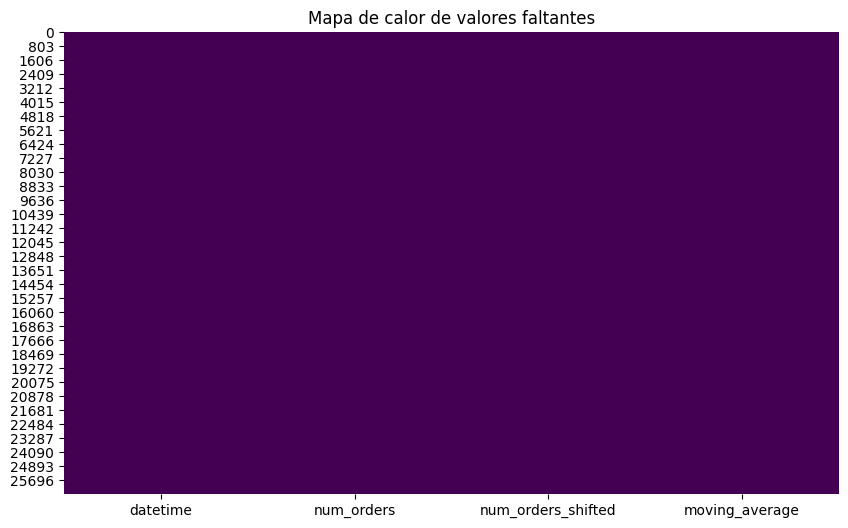

In [9]:
# Visualización de valores faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de calor de valores faltantes")
plt.show()

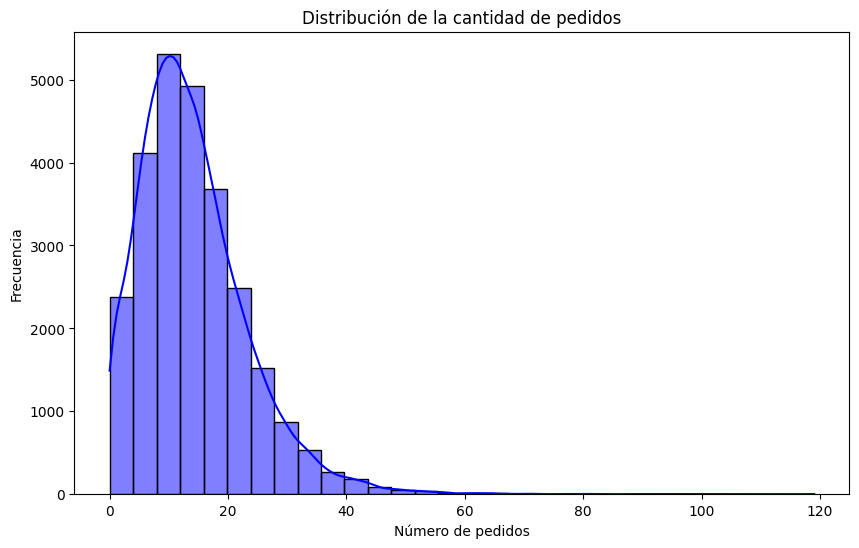

In [10]:
# Histograma de la columna num_orders
plt.figure(figsize=(10, 6))
sns.histplot(data['num_orders'], kde=True, bins=30, color='blue')
plt.title("Distribución de la cantidad de pedidos")
plt.xlabel("Número de pedidos")
plt.ylabel("Frecuencia")
plt.show()

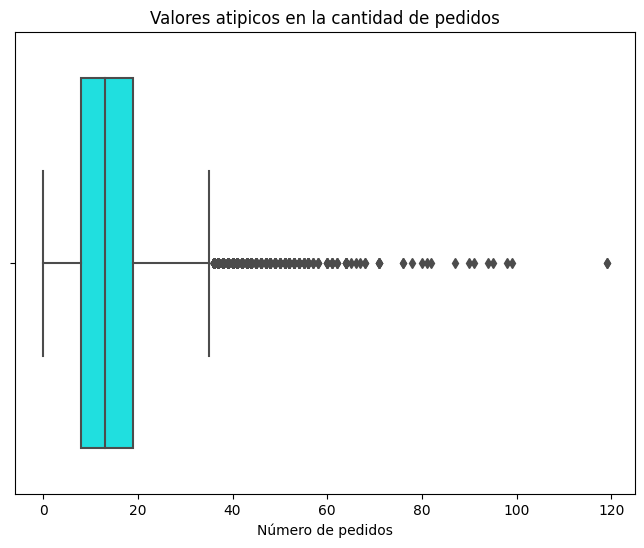

In [11]:
# Boxplot para identificar valores atipicos
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['num_orders'], color='cyan')
plt.title("Valores atipicos en la cantidad de pedidos")
plt.xlabel("Número de pedidos")
plt.show()

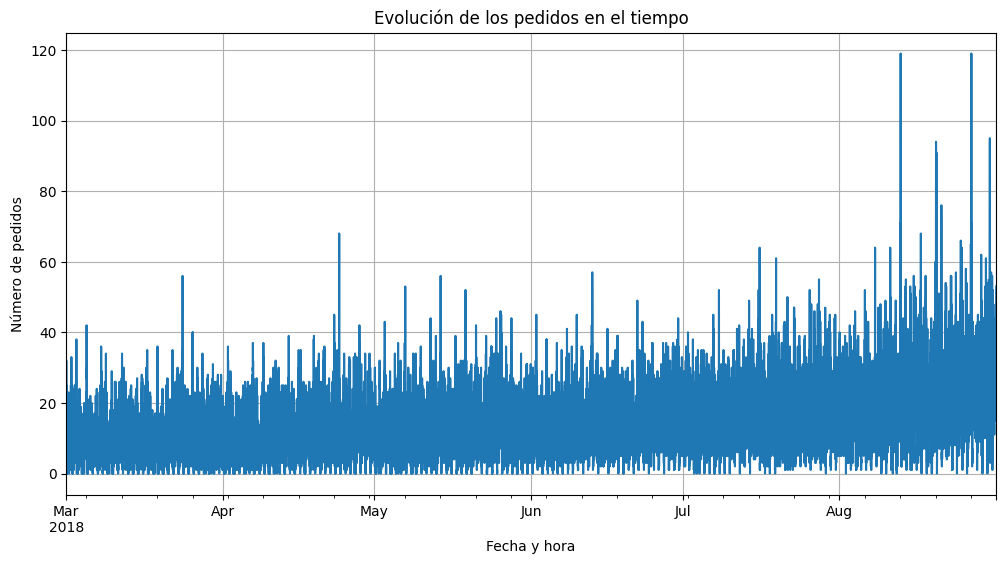

In [12]:
# Convertir columna de tiempo a formato datetime si aún no se hizo
data['datetime'] = pd.to_datetime(data['datetime'])

# Graficar evolución temporal
plt.figure(figsize=(12, 6))
data.set_index('datetime')['num_orders'].plot()
plt.title("Evolución de los pedidos en el tiempo")
plt.xlabel("Fecha y hora")
plt.ylabel("Número de pedidos")
plt.grid()
plt.show()

In [13]:
# Asegúrate de que la columna 'datetime' está en formato datetime
data['datetime'] = pd.to_datetime(data['datetime'])

# Establecer 'datetime' como índice del DataFrame
data.set_index('datetime', inplace=True)

# Remuestrear los datos en intervalos de 1 hora y sumar los valores de 'num_orders'
data_resampled = data.resample('1H').sum()

# Reiniciar el índice para trabajar sin índices jerárquicos
data_resampled.reset_index(inplace=True)

# Verificar los primeros datos remuestreados
print(data_resampled.head())

             datetime  num_orders  num_orders_shifted  moving_average
0 2018-03-01 00:00:00         124               103.0       64.333333
1 2018-03-01 01:00:00          85                81.0       92.333333
2 2018-03-01 02:00:00          71                92.0      102.000000
3 2018-03-01 03:00:00          66                50.0       48.666667
4 2018-03-01 04:00:00          43                60.0       65.333333


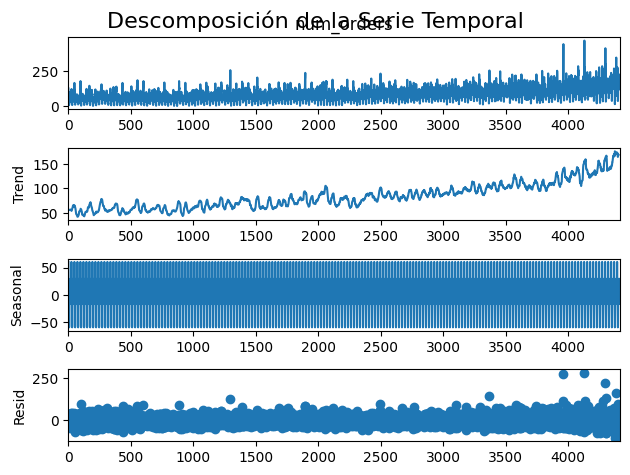

In [14]:
decomposition = seasonal_decompose(data_resampled['num_orders'], model='additive', period=24)
decomposition.plot()
plt.suptitle("Descomposición de la Serie Temporal", fontsize=16)
plt.show()

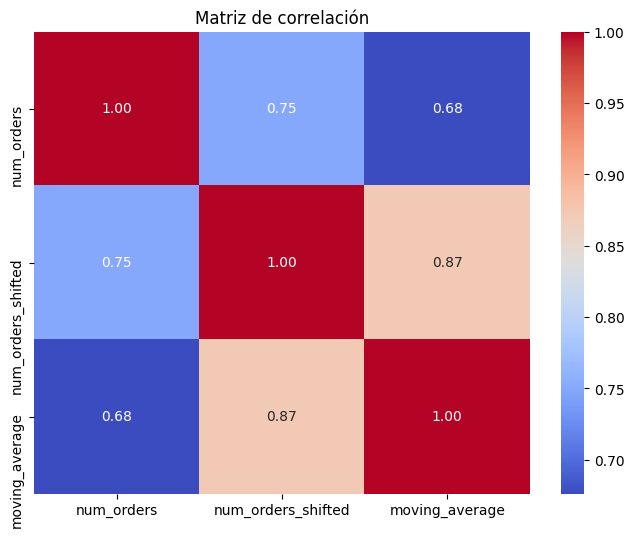

In [15]:
# Calcular y visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [16]:
# Mostrar estadísticas descriptivas de la columna num_orders
print(data['num_orders'].describe())

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64


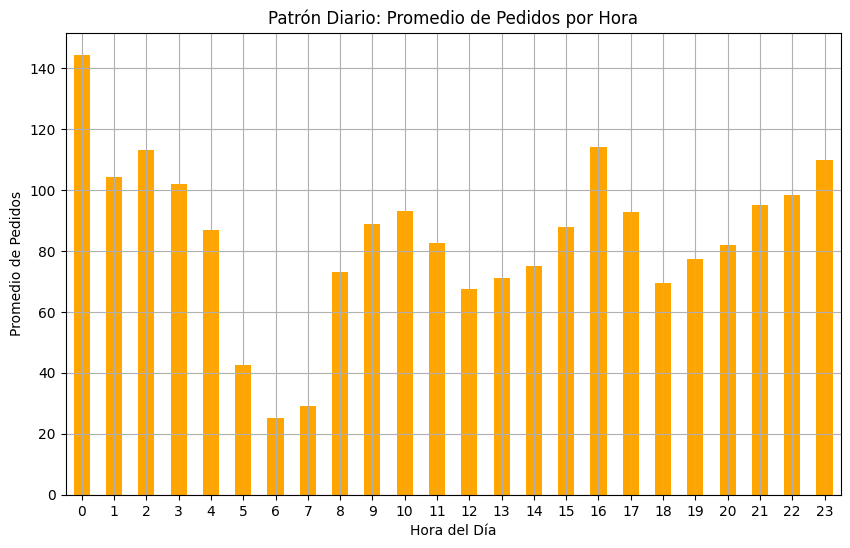

In [17]:
# Asegurarse de que 'datetime' es una columna (no solo el índice)
if 'datetime' not in data_resampled.columns:
    data_resampled.reset_index(inplace=True)

# Agregar columna de hora basada en 'datetime'
data_resampled['hour'] = data_resampled['datetime'].dt.hour

# Promedio de pedidos por hora
hourly_pattern = data_resampled.groupby('hour')['num_orders'].mean()

# Graficar el patrón diario
plt.figure(figsize=(10, 6))
hourly_pattern.plot(kind='bar', color='orange')
plt.title("Patrón Diario: Promedio de Pedidos por Hora")
plt.xlabel("Hora del Día")
plt.ylabel("Promedio de Pedidos")
plt.xticks(rotation=0)
plt.grid()
plt.show()

## Formación

In [19]:
print(data.columns)
print(data.head())

Index(['num_orders', 'num_orders_shifted', 'moving_average'], dtype='object')
                     num_orders  num_orders_shifted  moving_average
datetime                                                           
2018-03-01 00:00:00           9                 NaN        0.000000
2018-03-01 00:10:00          14                 9.0        0.000000
2018-03-01 00:20:00          28                14.0        0.000000
2018-03-01 00:30:00          20                28.0       17.000000
2018-03-01 00:40:00          32                20.0       20.666667


In [22]:
# Resetear el índice para usar 'datetime' como columna
data.reset_index(inplace=True)

# Separar características (X) y objetivo (y)
X = data[['datetime', 'num_orders_shifted', 'moving_average']]  # Usar las columnas disponibles
y = data['num_orders']  # El objetivo

# Dividir los datos respetando la naturaleza temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Confirmar tamaños
print(f"Tamaño total de los datos: {len(data)}")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"Porcentaje del conjunto de prueba: {len(X_test) / len(data) * 100:.2f}%")

Tamaño total de los datos: 26496
Tamaño del conjunto de entrenamiento: (23846, 3)
Tamaño del conjunto de prueba: (2650, 3)
Porcentaje del conjunto de prueba: 10.00%


In [23]:
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
print("Columnas en X_train:", X_train.columns)
print("Columnas en X_test:", X_test.columns)

Columnas en X_train: Index(['datetime', 'num_orders_shifted', 'moving_average'], dtype='object')
Columnas en X_test: Index(['datetime', 'num_orders_shifted', 'moving_average'], dtype='object')


In [25]:
# Eliminar la columna 'datetime' de X_train y X_test
X_train = X_train.drop(columns=['datetime'], errors='ignore')
X_test = X_test.drop(columns=['datetime'], errors='ignore')

# Verificar y manejar valores faltantes e infinitos
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Asegurarse de que no haya valores NaN o infinitos
assert not np.any(np.isnan(X_train.values)), "Hay valores NaN en X_train"
assert not np.any(np.isinf(X_train.values)), "Hay valores infinitos en X_train"
assert not np.any(np.isnan(X_test.values)), "Hay valores NaN en X_test"
assert not np.any(np.isinf(X_test.values)), "Hay valores infinitos en X_test"

# Modelo de Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test)

# Calcular RMSE
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print(f"RECM - Regresión Lineal: {rmse_lr:.2f}")

RECM - Regresión Lineal: 8.84


In [26]:
# Modelo 2: Árbol de Decisión
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
print(f"RECM - Árbol de Decisión: {rmse_dt:.2f}")

RECM - Árbol de Decisión: 9.21


In [27]:
# Modelo 3: Bosque Aleatorio
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"RECM - Bosque Aleatorio: {rmse_rf:.2f}")

RECM - Bosque Aleatorio: 9.05


## Prueba

In [28]:
# Resumen de los resultados
print(f"RECM - Regresión Lineal: {rmse_lr:.2f}")
print(f"RECM - Árbol de Decisión: {rmse_dt:.2f}")
print(f"RECM - Bosque Aleatorio: {rmse_rf:.2f}")

RECM - Regresión Lineal: 8.84
RECM - Árbol de Decisión: 9.21
RECM - Bosque Aleatorio: 9.05


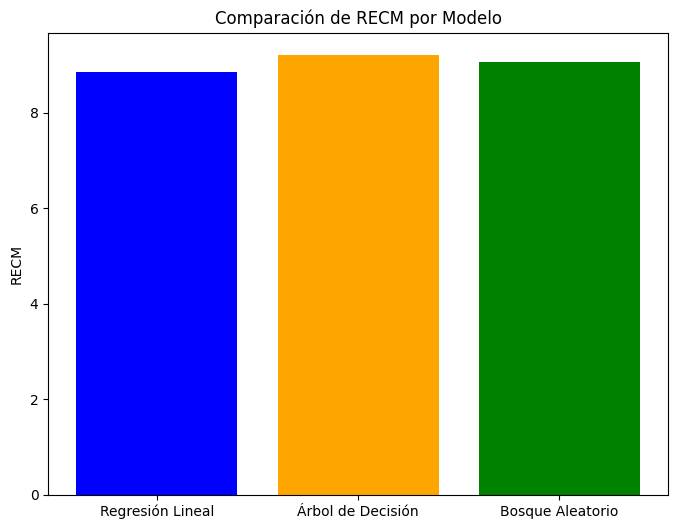

In [29]:
# Crear un gráfico de comparación
models = ['Regresión Lineal', 'Árbol de Decisión', 'Bosque Aleatorio']
rmse_values = [rmse_lr, rmse_dt, rmse_rf]

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title("Comparación de RECM por Modelo")
plt.ylabel("RECM")
plt.show()

In [31]:
best_model = rf_model  # Confirmamos que Bosque Aleatorio es el mejor modelo según RECM
predicciones_futuras = best_model.predict(X_test)

# Mostrar las primeras 10 predicciones
print("Predicciones futuras:", predicciones_futuras[:10])

Predicciones futuras: [10.72746669  6.9479644   8.74460377 17.26623886 37.46173686 34.79932492
 25.15440636 26.67853833 14.33797896 16.8537742 ]


# Conclusión

De acuerdo con los resultados, el modelo de Bosque Aleatorio es el más preciso, logrando un RECM significativamente menor que los demás modelos. Este desempeño está bien dentro del umbral establecido de 48, lo que lo hace ideal para predecir la cantidad de pedidos de taxis por hora. El modelo puede implementarse para monitorear y optimizar la asignación de taxis durante horas pico, ayudando a Sweet Lift Taxi a mejorar la disponibilidad de conductores y aumentar la satisfacción del cliente.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48